
# GAN-powered ML Improvement — Neuroblastoma EHRs (Colab)

_Colab-ready, modular notebook to enhance ML effectiveness on neuroblastoma-related datasets via **GAN-based augmentation**, **imputation**, and optional **Differential Privacy**._

**Last generated:** 2025-09-30 07:17 UTC


## Part 1 — Configuration & Setup (Mount dataset first)

In [ ]:

# ▶ If using Google Colab: mount Drive (uncomment)
# from google.colab import drive
# drive.mount('/content/drive')

# ▶ Option A: point to a file in Drive (example path):
# DATA_PATH = '/content/drive/MyDrive/GAN_ML_weakness/GSE3960_cleaned_data.csv'

# ▶ Option B: upload a local file interactively (Colab > Files > Upload)
# from google.colab import files
# uploaded = files.upload()  # then pick the filename below
# DATA_PATH = list(uploaded.keys())[0]

# ▶ Option C: remote URL (direct CSV/TSV/XLSX/JSON link)
# DATA_PATH = 'https://.../file.csv'

# Default placeholder (edit me in Colab)
DATA_PATH = '/content/drive/MyDrive/GAN_ML_weakness/GSE3960_cleaned_data.csv'

# Project flags
USE_GPU = False              # Flip if GPU runtime is enabled
ENABLE_DIFFERENTIAL_PRIVACY = False
RANDOM_SEED = 42

print('Configured DATA_PATH =', DATA_PATH)


Configured DATA_PATH = /content/drive/MyDrive/GAN_ML_weakness/GSE3960_cleaned_data.csv


In [ ]:
# Part 1 — Configuration & Setup (Mount dataset first)

# --- 1) Mount Google Drive (uncomment if your data lives in Drive) ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2) Define the intended dataset location (adjust these two lines only) ---
BASE_DIR = "/content/drive/MyDrive/GAN_ML_weakness"   # folder containing your file
FILENAME = "GSE3960_cleaned_data.csv"                  # dataset file name

# --- 3) Resolve the dataset path robustly (normalise & search fallbacks) ---
import os, glob, unicodedata
from pathlib import Path

def normalise_path(p: str) -> str:
    p = unicodedata.normalize("NFC", p)
    p = "".join(ch for ch in p if ch.isprintable())
    return p.strip()

intended = normalise_path(str(Path(BASE_DIR) / FILENAME))

if os.path.exists(intended):
    DATA_PATH = intended
    print("✅ Found file at intended path.")
else:
    print("⚠️ Not found at intended path. Searching MyDrive for the filename…")
    matches = []
    for root, dirs, files in os.walk('/content/drive/MyDrive'):
        if FILENAME in files:
            matches.append(os.path.join(root, FILENAME))
    if matches:
        print("✅ Found candidates:")
        for i, m in enumerate(matches, 1):
            print(f"{i}. {m}")
        DATA_PATH = matches[0]  # pick the first match by default
    else:
        # Try a glob within BASE_DIR allowing minor name variations
        cand = glob.glob(str(Path(BASE_DIR) / f"*{Path(FILENAME).stem}*.*"))
        if cand:
            DATA_PATH = cand[0]
            print("✅ Found by pattern:", DATA_PATH)
        else:
            raise FileNotFoundError(
                "File not found. Please verify BASE_DIR / FILENAME or copy path from Colab Files sidebar."
            )

print("DATA_PATH =", DATA_PATH)

# --- 4) (Optional) Copy into /content for faster I/O and simpler paths ---
COPY_TO_CONTENT = True
if COPY_TO_CONTENT:
    import shutil
    local_copy = f"/content/{Path(FILENAME).name}"
    shutil.copy2(DATA_PATH, local_copy)
    DATA_PATH = local_copy
    print("Copied to:", DATA_PATH, "| Exists:", os.path.exists(DATA_PATH))

# --- 5) Runtime & training configuration (GPU-aware) ---
# Differential Privacy toggle (used later only if available/needed)
ENABLE_DIFFERENTIAL_PRIVACY = False

# Reproducibility seed
RANDOM_SEED = 42

# GPU policy:
# - AUTO_SELECT_GPU=True enables GPU if a CUDA device (e.g., L4/T4/A100/V100) is present.
# - Set FORCE_CPU=True to keep everything on CPU (useful for quick/cheap tests).
# - To force GPU regardless of auto-detection: set AUTO_SELECT_GPU=False and USE_GPU=True.
AUTO_SELECT_GPU = True
FORCE_CPU = False
USE_GPU = False   # auto-updated below if AUTO_SELECT_GPU is True and CUDA is available

# Device probing
import subprocess, json, shutil

def _probe_nvidia_smi():
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader,nounits"],
            stderr=subprocess.STDOUT
        )
        first = out.decode("utf-8").strip().splitlines()[0]
        name, mem = [x.strip() for x in first.split(",")]
        return name, int(mem)  # MB
    except Exception:
        return None, None

GPU_NAME, GPU_MEM_MB = _probe_nvidia_smi()

try:
    import torch
    CUDA_OK = torch.cuda.is_available()
except Exception:
    CUDA_OK = False
    torch = None  # type: ignore

if FORCE_CPU:
    DEVICE = "cpu"
    USE_GPU = False
elif AUTO_SELECT_GPU and CUDA_OK:
    DEVICE = "cuda"
    USE_GPU = True
else:
    DEVICE = "cuda" if (not AUTO_SELECT_GPU and CUDA_OK) else "cpu"
    USE_GPU = (DEVICE == "cuda")

# Heuristic for batch sizes (you may use this later in training sections)
def recommended_batch_size(default_cpu=256, default_gpu=1024):
    if not USE_GPU or GPU_MEM_MB is None:
        return default_cpu
    if GPU_MEM_MB >= 22000:   # ~L4 24GB / A10
        return max(default_gpu, 2048)
    if GPU_MEM_MB >= 15000:   # ~T4 16GB / V100 16GB
        return max(default_gpu, 1536)
    if GPU_MEM_MB >= 8000:    # ~K80/P100 8–12GB
        return max(default_gpu, 1024)
    return 768

print("[Runtime]")
print(f"  DEVICE            : {DEVICE}")
print(f"  USE_GPU           : {USE_GPU}")
print(f"  GPU_NAME          : {GPU_NAME}")
print(f"  GPU_MEM_MB        : {GPU_MEM_MB}")
print(f"  SUGGESTED BATCH   : {recommended_batch_size()}")
print(f"  DATA_PATH         : {DATA_PATH}")


# Quick sanity checks
import os, sys, unicodedata, pathlib, glob

print("CWD:", os.getcwd())
print("Drive exists:", os.path.exists('/content/drive'))
print("MyDrive exists:", os.path.exists('/content/drive/MyDrive'))

# List the target folder to confirm spelling/case
!ls -la "/content/drive/MyDrive/GAN_ML_weakness" || echo "Folder not found"

Mounted at /content/drive
✅ Found file at intended path.
DATA_PATH = /content/drive/MyDrive/GAN_ML_weakness/GSE3960_cleaned_data.csv
Copied to: /content/GSE3960_cleaned_data.csv | Exists: True
[Runtime]
  DEVICE            : cuda
  USE_GPU           : True
  GPU_NAME          : NVIDIA L4
  GPU_MEM_MB        : 23034
  SUGGESTED BATCH   : 2048
  DATA_PATH         : /content/GSE3960_cleaned_data.csv
CWD: /content
Drive exists: True
MyDrive exists: True
total 10
drwx------ 2 root root 4096 Sep 30 12:39 artifacts
drwx------ 2 root root 4096 Sep 30 13:13 exports
-rw------- 1 root root 2033 Sep 30 07:03 GSE3960_cleaned_data.csv


### Part 1b — Environment installs

In [ ]:
# Part 1b — Environment installs

# --- Core scientific stack ---
!pip -q install pandas numpy scikit-learn matplotlib plotly requests beautifulsoup4 ipywidgets==8.1.2

# --- Clean previous conflicting installs (if any) ---
!pip -q uninstall -y sdv sdmetrics ctgan || true

# --- SDV (will pull a compatible sdmetrics) ---
# Try latest 1.27.x first; if dependency resolver fails, fall back to 1.26.x
!pip -q install "sdv>=1.27,<1.28" || pip -q install "sdv>=1.26,<1.27"

# --- Optional extras (do not block if unavailable) ---
# Additional imputers (optional). Safe to skip if not needed.
!pip -q install fancyimpute || echo "fancyimpute not available; skipping."

# Time-series/tabular generative models (optional). Skip if wheel is not provided for this Python.
!pip -q install ydata-synthetic || echo "ydata-synthetic not available for this Python; skipping."

# Differential Privacy (DP-SGD). Skip safely if incompatible with current PyTorch/CPU runtime.
!pip -q install opacus || echo "opacus not available for this Python; skipping."

# --- Sanity check: print resolved versions (ensure sdv pulled sdmetrics) ---
import importlib, sys
try:
    import sdv
    print("sdv version:", sdv.__version__)
    try:
        import sdmetrics
        print("sdmetrics version:", sdmetrics.__version__)
    except Exception as e:
        print("sdmetrics import error:", e)
except Exception as e:
    print("sdv import error:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 145.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.

## Part 2 — Dataset Ingestion & Basic Profiling

In [ ]:

import pandas as pd, numpy as np, json, os, io, sys, math, warnings
warnings.filterwarnings('ignore')

def load_table(path_or_url: str) -> pd.DataFrame:
    lower = path_or_url.lower()
    if lower.endswith('.csv'):   return pd.read_csv(path_or_url)
    if lower.endswith('.tsv') or lower.endswith('.txt'): return pd.read_csv(path_or_url, sep='\t')
    if lower.endswith('.xlsx') or lower.endswith('.xls'): return pd.read_excel(path_or_url)
    if lower.endswith('.json'):  return pd.read_json(path_or_url)
    try:
        return pd.read_csv(path_or_url)
    except Exception:
        return pd.read_csv(path_or_url, sep='\t')

df = load_table(DATA_PATH)
print('Shape:', df.shape)
display(df.head())
profile = {
    "rows": int(len(df)),
    "cols": int(df.shape[1]),
    "missing_rate_overall": float(df.isna().mean().mean()),
    "numeric_cols": int((df.dtypes != 'object').sum()),
    "categorical_cols": int((df.dtypes == 'object').sum())
}
print(json.dumps(profile, indent=2))


Shape: (101, 8)


,age_diagnosis_days,INSS_stage,MYCN_amplification,1p36_LOH,1p23_LOH,unbalanced11qLOH,17q_gain,tumor_percentage
0,9,1,0,0.0,0,0,0.0,90.0
1,12,1,0,0.0,0,0,0.0,90.0
2,17,1,0,0.0,0,0,0.0,100.0
3,19,1,0,0.0,1,0,0.0,95.0
4,26,1,0,0.0,0,0,0.0,NaN


{
  "rows": 101,
  "cols": 8,
  "missing_rate_overall": 0.035891089108910895,
  "numeric_cols": 6,
  "categorical_cols": 2
}


## Part 3 — Target definition & leakage-safe splits

In [ ]:
# Part 3 — Target definition & leakage-safe splits


# --- (Optionally) set the target manually here ---
# Example: TARGET_COLUMN = "MYCN_amplification"
# Example: TARGET_COLUMN = "INSS_stage"
TARGET_COLUMN = None  # leave as None to auto-select

# Choose task type: "classification" or "regression".
# If invalid or left None, it will be inferred below.
TASK_TYPE = "classification"

import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1) Summarise columns to help target selection ---
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "nunique": df.nunique(dropna=True),
    "missing_rate": df.isna().mean()
}).sort_values(["nunique", "missing_rate"], ascending=[True, True])

print("Columns summary (top 30 shown):")
try:
    display(summary.head(30))
except Exception:
    print(summary.head(30).to_string())

# --- 2) Propose sensible target candidates ---
NAME_HINTS = ["mycn", "inss", "stage", "status", "class", "label", "diagnosis", "outcome", "response", "risk"]
# Small-cardinality columns (good for classification)
small_card = summary.index[
    (summary["nunique"] >= 2) &
    (summary["nunique"] <= 10) &
    (summary["missing_rate"] < 0.60)
].tolist()

# Name-hinted subset of small-card columns, in a priority order
name_small = [c for c in df.columns if any(h in c.lower() for h in NAME_HINTS)]
name_small = [c for c in name_small if c in small_card]

# Priority within name hints: try to pick particularly relevant biomedical targets first
PRIORITY_ORDER = ["mycn", "inss", "stage", "status", "diagnosis", "outcome", "class", "response", "risk"]
def priority_key(c):
    lc = c.lower()
    for i, k in enumerate(PRIORITY_ORDER):
        if k in lc:
            return i
    return len(PRIORITY_ORDER)

name_small_sorted = sorted(name_small, key=priority_key)

# --- 3) Decide TARGET_COLUMN & TASK_TYPE ---
auto_selected = None
auto_task = None

if TARGET_COLUMN is None:
    if name_small_sorted:
        auto_selected = name_small_sorted[0]
        auto_task = "classification"
    elif small_card:
        # Choose the smallest-cardinality column; prefer integer/object over float for cleaner classes
        sc_df = summary.loc[small_card].copy()
        sc_df["dtype_rank"] = sc_df["dtype"].apply(lambda t: 0 if t.startswith("int") or t=="object" else (1 if t.startswith("float") else 2))
        sc_df = sc_df.sort_values(["nunique", "dtype_rank", "missing_rate"])
        auto_selected = sc_df.index[0]
        auto_task = "classification"
    else:
        # Fallback: pick a high-cardinality numeric column and treat as regression
        high_num = summary[(summary["nunique"] >= 20) & (summary["dtype"].str.contains("int|float"))]
        if len(high_num):
            auto_selected = high_num.index[0]
            auto_task = "regression"
        else:
            auto_selected = None

    TARGET_COLUMN = auto_selected

# If task was not explicitly valid, infer from selected target
if TASK_TYPE not in ("classification", "regression"):
    TASK_TYPE = auto_task if auto_task is not None else "classification"

print("Proposed TARGET candidates (small-cardinality):", small_card)
print("Name-hinted small-card candidates:", name_small_sorted)
print("Chosen TARGET_COLUMN:", TARGET_COLUMN)
print("Chosen TASK_TYPE:", TASK_TYPE)
assert TARGET_COLUMN is not None, (
    "Please set TARGET_COLUMN to the correct column name (see the 'summary' table above)."
)

# --- 4) Prepare y and optional normalisation for binary strings ---
y = df[TARGET_COLUMN].copy()

def _normalise_binary_series(s: pd.Series) -> pd.Series:
    # Map common biomedical/boolean strings to {0,1}; leave others untouched
    mapping = {
        "yes": 1, "y": 1, "true": 1, "t": 1, "pos": 1, "positive": 1, "amplified": 1, "amplification": 1,
        "no": 0,  "n": 0, "false": 0, "f": 0, "neg": 0, "negative": 0, "not amplified": 0, "wildtype": 0
    }
    def _map_val(v):
        if pd.isna(v): return pd.NA
        s = str(v).strip().lower()
        return mapping[s] if s in mapping else v
    return s.map(_map_val)

# Apply normalisation for object-like low-cardinality targets (classification)
if TASK_TYPE == "classification" and y.dtype == "object" and y.nunique(dropna=True) <= 10:
    y = _normalise_binary_series(y)

# --- 5) Build X by dropping the target ---
X = df.drop(columns=[TARGET_COLUMN])

# --- 6) Leakage-safe splits with safe stratification ---
train_size, val_size = 0.70, 0.15
test_size = 1.0 - (train_size + val_size)

def stratify_if_safe(labels: pd.Series):
    # Use stratification only if every class has at least 2 samples
    vc = labels.value_counts(dropna=False)
    if (vc.min() >= 2) and (vc.nunique() >= 2):
        return labels
    return None

if TASK_TYPE == "classification":
    stratify_arg = stratify_if_safe(y)
else:
    stratify_arg = None

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y,
    test_size=(1.0 - train_size),
    stratify=stratify_arg,
    random_state=RANDOM_SEED
)

# Second split
rel_val = val_size / (val_size + test_size)
if TASK_TYPE == "classification":
    stratify_tmp = stratify_if_safe(y_tmp)
else:
    stratify_tmp = None

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp,
    test_size=(1.0 - rel_val),
    stratify=stratify_tmp,
    random_state=RANDOM_SEED
)

# --- 7) Report shapes and class balance ---
print("Split shapes:")
print("  X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

if TASK_TYPE == "classification":
    print("y_train distribution:")
    try:
        display(pd.Series(y_train).value_counts(dropna=False))
    except Exception:
        print(pd.Series(y_train).value_counts(dropna=False).to_string())


Columns summary (top 30 shown):


,dtype,nunique,missing_rate
MYCN_amplification,int64,2,0.000000
1p36_LOH,float64,2,0.009901
17q_gain,float64,2,0.118812
INSS_stage,int64,3,0.000000
1p23_LOH,object,3,0.009901
unbalanced11qLOH,object,3,0.009901
tumor_percentage,float64,20,0.138614
age_diagnosis_days,int64,97,0.000000


Proposed TARGET candidates (small-cardinality): ['MYCN_amplification', '1p36_LOH', ' 17q_gain', 'INSS_stage', '1p23_LOH', 'unbalanced11qLOH']
Name-hinted small-card candidates: ['MYCN_amplification', 'INSS_stage']
Chosen TARGET_COLUMN: MYCN_amplification
Chosen TASK_TYPE: classification
Split shapes:
  X_train: (70, 7) X_val: (15, 7) X_test: (16, 7)
y_train distribution:


,count
MYCN_amplification,
0,56
1,14


## Part 4 — Preprocessing & Imputation

In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

num_cols = [c for c in X_train.columns if str(X_train[c].dtype) != 'object']
cat_cols = [c for c in X_train.columns if c not in num_cols]

imputation_strategy = 'iterative'  # 'mean' | 'median' | 'most_frequent' | 'iterative' | 'gain'
scale_numeric = True
onehot_categoricals = True

num_steps = []
if imputation_strategy in ['mean','median','most_frequent']:
    num_steps.append(('impute', SimpleImputer(strategy=imputation_strategy)))
elif imputation_strategy == 'iterative':
    num_steps.append(('impute', IterativeImputer(random_state=RANDOM_SEED, sample_posterior=True, max_iter=15)))
else:
    num_steps.append(('impute', IterativeImputer(random_state=RANDOM_SEED, sample_posterior=True)))

if scale_numeric:
    num_steps.append(('scale', StandardScaler()))

num_pipe = Pipeline(num_steps)
cat_pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                     ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False if onehot_categoricals else True))])

pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
Xtr = pre.fit_transform(X_train); Xva = pre.transform(X_val); Xte = pre.transform(X_test)
print('Transformed shapes:', Xtr.shape, Xva.shape, Xte.shape)

if imputation_strategy == 'gain':
    print('GAIN wiring note: apply GAIN on raw tables pre-split to avoid leakage, then repeat splitting.')


Transformed shapes: (70, 11) (15, 11) (16, 11)


In [ ]:
# Part 4b — Advanced imputation & comparison (pre-augmentation)

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Identify numeric and categorical columns from training data
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in X_train.columns if (not pd.api.types.is_numeric_dtype(df[c]))]

def build_pre(imputer_kind="simple"):
    """Return a ColumnTransformer with the requested imputer for numeric columns."""
    if imputer_kind == "knn":
        num_imputer = KNNImputer(n_neighbors=5, weights="distance")
    elif imputer_kind == "iterative":
        num_imputer = IterativeImputer(random_state=RANDOM_SEED, max_iter=15, sample_posterior=False)
    else:
        num_imputer = SimpleImputer(strategy="median")

    pre_local = ColumnTransformer(
        transformers=[
            ("num", make_pipeline(num_imputer, StandardScaler()), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre_local

# Optional: try fancyimpute (MICE) if available
has_fancy = False
try:
    from fancyimpute import IterativeImputer as FIter
    has_fancy = True
except Exception:
    pass

candidates = ["simple", "knn", "iterative"] + (["fancy"] if has_fancy else [])

def pre_for(kind):
    if kind == "fancy":
        pre_f = ColumnTransformer(
            transformers=[
                ("num", make_pipeline(FIter(verbose=False), StandardScaler()), num_cols),
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
            ],
            remainder="drop",
            sparse_threshold=0.3
        )
        return pre_f
    return build_pre(kind)

# Quick CV to rank imputers (on the current TRAIN only)
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scores = []
for kind in candidates:
    aurocs, auprcs = [], []
    for tr_idx, va_idx in kf.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
        pipe = make_pipeline(pre_for(kind), clf)
        pipe.fit(X_tr, y_tr)
        proba = pipe.predict_proba(X_va)[:, 1]
        aurocs.append(roc_auc_score(y_va, proba))
        auprcs.append(average_precision_score(y_va, proba))
    scores.append({"imputer": kind, "auroc": np.mean(aurocs), "auprc": np.mean(auprcs)})

scores_df = pd.DataFrame(scores).sort_values(["auprc", "auroc"], ascending=False)
print("Imputation candidates ranked (mean CV on train):")
display(scores_df)

# Choose best and rebuild your global preprocessor 'pre'
BEST_IMPUTER = scores_df.iloc[0]["imputer"]
print("Chosen imputer:", BEST_IMPUTER)
pre = pre_for(BEST_IMPUTER)


Imputation candidates ranked (mean CV on train):


,imputer,auroc,auprc
1,knn,0.940909,0.903333
2,iterative,0.922727,0.836667
3,fancy,0.922727,0.836667
0,simple,0.900000,0.778571


Chosen imputer: knn


## Part 5 — Baseline ML (pre-augmentation)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, y_train)

def eval_model(model, X, y, tag=''):
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X)[:,1]
    else:
        proba = model.decision_function(X)
    auroc = roc_auc_score(y, proba)
    auprc = average_precision_score(y, proba)
    print(f"{tag} AUROC={auroc:.4f} | AUPRC={auprc:.4f}")
    return proba, auroc, auprc

p_val, auroc_val_base, auprc_val_base = eval_model(clf, Xva, y_val, tag='[BASELINE][VAL]')
p_test, auroc_test_base, auprc_test_base = eval_model(clf, Xte, y_test, tag='[BASELINE][TEST]')


[BASELINE][VAL] AUROC=0.8889 | AUPRC=0.7222
[BASELINE][TEST] AUROC=0.9744 | AUPRC=0.9167


In [ ]:
# Part 5b — Cross-validation baseline check

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Define model (balanced to handle class imbalance)
clf = LogisticRegression(max_iter=2000, class_weight="balanced")

# We reuse the preprocessor "pre" fitted earlier on the training set,
# but for fairness we will re-fit it within each fold to avoid leakage.
# Hence we wrap pre + clf into a pipeline.
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

pipe = make_pipeline(pre, clf)

# Prepare full X, y (not split yet) for CV
X_full = df.drop(columns=[TARGET_COLUMN])
y_full = df[TARGET_COLUMN]

# Ensure stratification (important with 14 positives vs 56 negatives)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

fold_results = []
print("=== Cross-validation results (5-fold stratified) ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full, y_full), 1):
    X_tr, X_va = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_va = y_full.iloc[train_idx], y_full.iloc[val_idx]

    model = clone(pipe)
    model.fit(X_tr, y_tr)

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_va)[:, 1]
    else:
        proba = model.decision_function(X_va)

    auroc = roc_auc_score(y_va, proba)
    auprc = average_precision_score(y_va, proba)

    fold_results.append({"fold": fold, "auroc": auroc, "auprc": auprc})

    print(f"Fold {fold}: AUROC={auroc:.4f} | AUPRC={auprc:.4f} | "
          f"train_balance={np.bincount(y_tr)[0]}:{np.bincount(y_tr)[1]} "
          f"val_balance={np.bincount(y_va)[0]}:{np.bincount(y_va)[1]}")

cv_df = pd.DataFrame(fold_results)
print("\n=== Summary across folds ===")
print(cv_df.describe()[["auroc", "auprc"]].T)

mean_auroc = cv_df["auroc"].mean()
std_auroc = cv_df["auroc"].std()
mean_auprc = cv_df["auprc"].mean()
std_auprc = cv_df["auprc"].std()

print(f"\nMean AUROC = {mean_auroc:.4f} ± {std_auroc:.4f}")
print(f"Mean AUPRC = {mean_auprc:.4f} ± {std_auprc:.4f}")


=== Cross-validation results (5-fold stratified) ===
Fold 1: AUROC=1.0000 | AUPRC=1.0000 | train_balance=64:16 val_balance=17:4
Fold 2: AUROC=0.9375 | AUPRC=0.8750 | train_balance=65:16 val_balance=16:4
Fold 3: AUROC=0.8750 | AUPRC=0.8333 | train_balance=65:16 val_balance=16:4
Fold 4: AUROC=0.9375 | AUPRC=0.6792 | train_balance=65:16 val_balance=16:4
Fold 5: AUROC=0.9844 | AUPRC=0.9500 | train_balance=65:16 val_balance=16:4

=== Summary across folds ===
       count      mean       std       min       25%     50%       75%  max
auroc    5.0  0.946875  0.048914  0.875000  0.937500  0.9375  0.984375  1.0
auprc    5.0  0.867500  0.123547  0.679167  0.833333  0.8750  0.950000  1.0

Mean AUROC = 0.9469 ± 0.0489
Mean AUPRC = 0.8675 ± 0.1235


## Part 6 — GAN-based Augmentation (CTGAN/TVAE via SDV) with optional Differential Privacy

In [ ]:
# Part 6 — GAN-based Augmentation (SDV Preset)

import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset

# Conservative synthetic size for small datasets (~100 rows)
SYN_ROWS = 300  # tune to 200–500 if needed

# --- A) UNCONDITIONAL augmentation (metadata aligned with features only) ---
# Use exactly the same columns you will pass to .fit()
feature_cols = list(X_train.columns)  # target is excluded by construction

train_features_only = X_train.copy()

meta = SingleTableMetadata()
meta.detect_from_dataframe(train_features_only)  # detect on the SAME columns we fit

model_uncond = SingleTablePreset(meta, name="FAST_ML")
model_uncond.fit(train_features_only)            # fit on features only (no target inside)
synthetic_uncond = model_uncond.sample(SYN_ROWS) # unconditional synthetic features
display(synthetic_uncond.head())

# Optional quality check (API may vary across sdmetrics versions; ignore if it fails)
try:
    from sdmetrics.reports.single_table import QualityReport
    qr = QualityReport()
    qr.generate(real_data=train_features_only, synthetic_data=synthetic_uncond, metadata=meta)
    # Try multiple accessors depending on version
    shown = False
    for attr in ("get_score", "get_summary", "get_properties"):
        if hasattr(qr, attr):
            print("Quality report via:", attr)
            print(getattr(qr, attr)())
            shown = True
            break
    if not shown:
        try:
            print(qr.get_details(property_name="Column Shapes").head())
        except Exception:
            pass
except Exception as e:
    print("Quality report unavailable or API changed; continuing. Reason:", str(e))

# Save for Part 8 (merge step)
synthetic = synthetic_uncond.copy()


,age_diagnosis_days,INSS_stage,1p36_LOH,1p23_LOH,unbalanced11qLOH,17q_gain,tumor_percentage
0,471,4,0.0,1,0,1.0,98.185319
1,1723,1,0.0,0,0,0.0,95.263639
2,129,4,0.0,0,0,0.0,95.774990
3,1748,3,0.0,1,0,0.0,NaN
4,931,4,NaN,0,0,0.0,89.048458


Quality report unavailable or API changed; continuing. Reason: Expected a dictionary but received a 'SingleTableMetadata' instead. For SDV metadata objects, please use the 'to_dict' function to convert it to a dictionary.


In [ ]:
# --- B) CONDITIONAL augmentation (fit per-class and sample positives) --- KEEP THIS ONE FOR OUR PAPER (A is not well-balanced among classes)
# Goal: generate extra positives to approach a balanced train set.

pos_mask = (y_train == 1)
neg_mask = (y_train == 0)

n_pos = int(pos_mask.sum())
n_neg = int(neg_mask.sum())

# Target: balance to 1:1 by adding positives
n_pos_needed = max(0, n_neg - n_pos)
# Keep it conservative on very small datasets
n_pos_needed = min(n_pos_needed, max(100, n_pos_needed))  # cap optional, adjust as you wish

print(f"[Conditional] Train counts: neg={n_neg} pos={n_pos} → synth positives to add ≈ {n_pos_needed}")

# Build metadata on features-only (same columns), but fit only on positive-class rows
train_pos_features = X_train.loc[pos_mask].copy()

meta_pos = SingleTableMetadata()
meta_pos.detect_from_dataframe(train_pos_features)

model_pos = SingleTablePreset(meta_pos, name="FAST_ML")
model_pos.fit(train_pos_features)

synthetic_pos = model_pos.sample(max(0, n_pos_needed))
synthetic_pos["__synthetic_target__"] = 1  # we will use this column in Part 8

# (Optionally) also generate a small set of negatives to avoid overfitting to positives:
# train_neg_features = X_train.loc[neg_mask].copy()
# meta_neg = SingleTableMetadata(); meta_neg.detect_from_dataframe(train_neg_features)
# model_neg = SingleTablePreset(meta_neg, name="FAST_ML"); model_neg.fit(train_neg_features)
# synthetic_neg = model_neg.sample(min(n_pos_needed // 4, 200))
# synthetic_neg["__synthetic_target__"] = 0

# Concatenate conditional synthetic tables (here only positives)
synthetic_cond = synthetic_pos.copy()
display(synthetic_cond.head())

# Use this in Part 8 instead of `synthetic_uncond`:
# synthetic = synthetic_cond.copy()


[Conditional] Train counts: neg=56 pos=14 → synth positives to add ≈ 42


,age_diagnosis_days,INSS_stage,1p36_LOH,1p23_LOH,unbalanced11qLOH,17q_gain,tumor_percentage,__synthetic_target__
0,7121010,4,0.709356,0,0,0.199151,91.321906,1
1,13517545,4,1.000000,0,0,0.705975,92.750429,1
2,15257355,4,0.783313,0,0,0.546013,94.331807,1
3,7919252,4,0.740530,0,0,1.000000,92.731269,1
4,5300583,4,0.546183,1,0,0.114568,88.907720,1


In [ ]:
# Part 6B.1 — Synthetic data sanitisation (clip to real ranges + impute + drop near-duplicates)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def sanitise_synthetic(
    synth_df: pd.DataFrame,
    real_df: pd.DataFrame,
    drop_threshold: float = 0.25,
    use_percentile: bool = False,
    percentile: float = 5.0,
):
    """
    - Clips numeric columns of synthetic data to the min/max observed in real data.
    - Imputes numeric NaNs using the real-data median (both real and synthetic).
    - Computes NN distances in standardised numeric space and drops synthetic rows
      that are too close to any real sample.
    - If use_percentile=True, the threshold becomes the given percentile of the
      real-vs-real nearest-neighbour distance distribution (data-driven).
    """

    # Work on copies
    synth = synth_df.copy()
    real = real_df.copy()

    # 1) Select numeric columns (ignore categoricals for distance computation)
    num_cols = [c for c in real.columns if pd.api.types.is_numeric_dtype(real[c])]
    if not num_cols:
        print("[Sanitiser] No numeric columns found. Returning input unchanged.")
        return synth

    # 2) Clip synthetic numeric columns to real min/max
    for c in num_cols:
        mn, mx = np.nanmin(real[c].values), np.nanmax(real[c].values)
        synth[c] = np.clip(synth[c].values, mn, mx)

    # 3) Impute numeric NaNs using real-data medians
    real_medians = real[num_cols].median()
    real_num = real[num_cols].copy().fillna(real_medians)
    synth_num = synth[num_cols].copy().fillna(real_medians)

    # If any remaining NaNs slipped through (e.g., all-NaN columns), drop those rows for distance calc
    mask_valid_synth = ~synth_num.isna().any(axis=1)
    if not mask_valid_synth.all():
        dropped = int((~mask_valid_synth).sum())
        print(f"[Sanitiser] Dropping {dropped} synthetic rows with unresolved NaNs (distance step only).")
    synth_num = synth_num.loc[mask_valid_synth]
    synth_valid_idx = synth_num.index

    # 4) Standardise numeric space by fitting on REAL data
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_num.values)
    synth_scaled = scaler.transform(synth_num.values)

    # 5) Decide threshold
    if use_percentile:
        # Compute NN distances among REAL points to derive a data-driven threshold
        nn_real = NearestNeighbors(n_neighbors=2).fit(real_scaled)
        dist_real, _ = nn_real.kneighbors(real_scaled)
        # Skip distance to self (0); take the nearest non-self neighbour (column 1)
        real_nn = dist_real[:, 1]
        thr = np.percentile(real_nn, percentile)
        print(f"[Sanitiser] Using percentile-based threshold: {percentile}th → {thr:.4f}")
    else:
        thr = float(drop_threshold)
        print(f"[Sanitiser] Using absolute distance threshold: {thr:.4f}")

    # 6) Nearest-neighbour distance to REAL for each SYNTH
    nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
    dists, _ = nn.kneighbors(synth_scaled)
    dists = dists.ravel()

    # 7) Keep only sufficiently far synthetic rows
    keep_mask = dists >= thr
    kept_idx = synth_valid_idx[keep_mask]
    cleaned = synth.loc[kept_idx].reset_index(drop=True)

    removed = int(len(synth) - len(cleaned))
    print(f"[Sanitiser] Removed {removed} synthetic rows as near-duplicates.")

    return cleaned

# Apply to conditional positives BEFORE Part 8
assert 'synthetic_cond' in globals(), "Run Part 6B first."

# Option A: fixed absolute threshold (good starting point)
synthetic_cond = sanitise_synthetic(
    synthetic_cond, X_train,
    drop_threshold=0.25,   # try 0.25–0.40 if still too perfect
    use_percentile=False
)

# Option B: data-driven threshold (uncomment to try)
# synthetic_cond = sanitise_synthetic(
#     synthetic_cond, X_train,
#     use_percentile=True, percentile=5.0  # 5th percentile of real-vs-real NN distances
# )


[Sanitiser] Using absolute distance threshold: 0.2500
[Sanitiser] Removed 0 synthetic rows as near-duplicates.


In [ ]:
# Part 6C — GAN-assisted imputation for selected numeric columns

import numpy as np
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset

# Columns to impute via GAN (conservative choice; adjust as needed)
GAN_IMPUTE_COLS = [c for c in ["tumor_percentage"] if c in X_train.columns]

if len(GAN_IMPUTE_COLS):
    # Fit an unconditional model on TRAIN features (post-sanitiser training split)
    meta_imp = SingleTableMetadata()
    meta_imp.detect_from_dataframe(X_train)

    gan_imp = SingleTablePreset(meta_imp, name="FAST_ML")
    gan_imp.fit(X_train)

    def gan_impute_frame(frame: pd.DataFrame, n_tries=5):
        out = frame.copy()
        for col in GAN_IMPUTE_COLS:
            miss = out[col].isna()
            if miss.any():
                # Sample small batches and fill NaNs with nearest quantile from synthetic distribution
                synth = gan_imp.sample(max(200, miss.sum()))
                # Clip to real range
                mn, mx = X_train[col].min(), X_train[col].max()
                synth[col] = synth[col].clip(mn, mx)
                # Use the synthetic column's empirical distribution to fill
                fill_vals = synth[col].dropna().sample(miss.sum(), replace=True, random_state=RANDOM_SEED).values
                out.loc[miss, col] = fill_vals
        return out

    # Impute missing only in TRAIN/VAL/TEST feature frames (keep y untouched)
    X_train = gan_impute_frame(X_train)
    X_val   = gan_impute_frame(X_val)
    X_test  = gan_impute_frame(X_test)
    print("[GAN-impute] Completed for columns:", GAN_IMPUTE_COLS)
else:
    print("[GAN-impute] No eligible columns configured; skipping.")


[GAN-impute] Completed for columns: ['tumor_percentage']


In [ ]:
# Part 6D — Synthetic data quality checks & constraints

import numpy as np
import pandas as pd

def enforce_quality_rules(synth: pd.DataFrame, ref: pd.DataFrame) -> pd.DataFrame:
    s = synth.copy()

    # 1) Numeric ranges to observed real bounds (already partially done in sanitiser; keep here for safety)
    num_cols = [c for c in ref.columns if pd.api.types.is_numeric_dtype(ref[c])]
    for c in num_cols:
        s[c] = s[c].clip(ref[c].min(), ref[c].max())

    # 2) Categorical domain restriction: replace unseen levels by mode
    cat_cols = [c for c in ref.columns if c not in num_cols]
    for c in cat_cols:
        if c in s.columns:
            allowed = set(ref[c].dropna().unique().tolist())
            if len(allowed):
                mode = ref[c].mode().iloc[0]
                s.loc[~s[c].isin(allowed), c] = mode

    # 3) Clinical rule examples (adapt as needed)
    # INSS_stage must be one of {1,2,3,4} if present
    if "INSS_stage" in s.columns:
        s.loc[~s["INSS_stage"].isin([1,2,3,4]), "INSS_stage"] = ref["INSS_stage"].mode().iloc[0]

    return s

# Apply to your chosen synthetic table used in Part 8
if 'synthetic_cond' in globals():
    synthetic_cond = enforce_quality_rules(synthetic_cond, X_train)
    print("[Quality] Applied constraints to conditional synthetic data.")


[Quality] Applied constraints to conditional synthetic data.


## Part 7 — (Optional) DP-SGD GAN (starter template)

In [ ]:

# Minimal DP-GAN skeleton with Opacus appears here (fill in only if you enable DP in experiments).
# See the previous notebook version for a full minimal example.
print('Refer to the template to implement DP-SGD with Opacus for strict privacy accounting.')


Refer to the template to implement DP-SGD with Opacus for strict privacy accounting.


## Part 8 — Merge synthetic data & retrain

In [ ]:
# Part 8 — Merge conditional synthetic data & retrain

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Expect `synthetic_cond` from Part 6B:
#   - columns: same feature columns as X_train
#   - has a column "__synthetic_target__" set to 1 (positives)

assert 'synthetic_cond' in globals(), "synthetic_cond not found. Please run Part 6B first."
assert set(synthetic_cond.columns) >= set(X_train.columns), "Mismatch in synthetic feature columns."

# Align columns to training features
aug_feat = synthetic_cond.reindex(columns=X_train.columns, fill_value=np.nan)

# Synthetic labels (all positives by design)
synth_labels = pd.Series(np.ones(len(aug_feat), dtype=y_train.dtype), index=aug_feat.index)

# Combine real train with synthetic positives
combo_raw = pd.concat([X_train.reset_index(drop=True), aug_feat.reset_index(drop=True)], axis=0)
combo_y   = pd.concat([y_train.reset_index(drop=True), synth_labels.reset_index(drop=True)], axis=0)

print("[Augment] Real train size:", len(X_train), "| Synthetic +:", len(aug_feat), "| Combined:", len(combo_raw))
print("[Augment] Class balance after merge:")
print(combo_y.value_counts(dropna=False))

# Refit preprocessor ONLY on the (augmented) training data to avoid leakage
Xtr_combo = pre.fit_transform(combo_raw)

# Train a simple baseline on augmented data (balanced helps if still slightly imbalanced)
clf_aug = LogisticRegression(max_iter=2000, class_weight='balanced')
clf_aug.fit(Xtr_combo, combo_y)

# Evaluate on untouched validation/test splits
def _eval(model, X, y, tag=""):
    from sklearn.metrics import roc_auc_score, average_precision_score
    proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)
    auroc = roc_auc_score(y, proba)
    auprc = average_precision_score(y, proba)
    print(f"{tag} AUROC={auroc:.4f} | AUPRC={auprc:.4f}")
    return auroc, auprc

Xva = pre.transform(X_val)
Xte = pre.transform(X_test)

_ = _eval(clf_aug, Xva, y_val,  "[AUGMENTED][VAL]")
_ = _eval(clf_aug, Xte, y_test, "[AUGMENTED][TEST]")


[Augment] Real train size: 70 | Synthetic +: 42 | Combined: 112
[Augment] Class balance after merge:
0    56
1    56
Name: count, dtype: int64
[AUGMENTED][VAL] AUROC=0.9444 | AUPRC=0.8667
[AUGMENTED][TEST] AUROC=0.9487 | AUPRC=0.8667


In [ ]:
# Part 8b — Cross-validation on augmented data (per-fold conditional synthesis, leakage-safe)

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset

# Full dataset (no pre-split): we will create train/val folds here
X_full = df.drop(columns=[TARGET_COLUMN]).copy()
y_full = df[TARGET_COLUMN].copy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
rows = []

print("=== Cross-validation with per-fold conditional augmentation (5-fold) ===")
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_full, y_full), 1):
    X_tr, X_va = X_full.iloc[tr_idx].copy(), X_full.iloc[va_idx].copy()
    y_tr, y_va = y_full.iloc[tr_idx].copy(), y_full.iloc[va_idx].copy()

    # --- Fit conditional generator on positives of the TRAIN fold only ---
    pos_mask = (y_tr == 1)
    neg_mask = (y_tr == 0)
    n_pos, n_neg = int(pos_mask.sum()), int(neg_mask.sum())

    # Target: approach 1:1 balance within the train fold
    n_pos_needed = max(0, n_neg - n_pos)

    if n_pos >= 5 and n_pos_needed > 0:
        train_pos_features = X_tr.loc[pos_mask].copy()

        meta_pos = SingleTableMetadata()
        meta_pos.detect_from_dataframe(train_pos_features)

        model_pos = SingleTablePreset(meta_pos, name="FAST_ML")
        model_pos.fit(train_pos_features)

        synth_pos = model_pos.sample(n_pos_needed).reindex(columns=X_tr.columns, fill_value=np.nan)
        y_synth = pd.Series(np.ones(len(synth_pos), dtype=y_tr.dtype), index=synth_pos.index)

        X_tr_aug = pd.concat([X_tr, synth_pos], axis=0, ignore_index=True)
        y_tr_aug = pd.concat([y_tr, y_synth], axis=0, ignore_index=True)
    else:
        # Not enough positives to train a conditional generator → skip augmentation for this fold
        X_tr_aug, y_tr_aug = X_tr, y_tr

    # --- Refit the preprocessor within each fold (clone to avoid leakage) ---
    clf_fold = LogisticRegression(max_iter=2000, class_weight="balanced")
    pre_fold = clone(pre)  # reinitialise transformers per fold
    pipe = make_pipeline(pre_fold, clf_fold)

    pipe.fit(X_tr_aug, y_tr_aug)

    # --- Evaluate ---
    proba = pipe.predict_proba(X_va)[:, 1] if hasattr(pipe, "predict_proba") else pipe.decision_function(X_va)
    auroc = roc_auc_score(y_va, proba)
    auprc = average_precision_score(y_va, proba)

    rows.append({
        "fold": fold,
        "auroc": auroc,
        "auprc": auprc,
        "train_counts": f"{(y_tr==0).sum()}:{(y_tr==1).sum()}",
        "train_aug_counts": f"{(y_tr_aug==0).sum()}:{(y_tr_aug==1).sum()}",
        "val_counts": f"{(y_va==0).sum()}:{(y_va==1).sum()}"
    })

    print(
        f"Fold {fold}: AUROC={auroc:.4f} | AUPRC={auprc:.4f} | "
        f"train={rows[-1]['train_counts']} → train_aug={rows[-1]['train_aug_counts']} | "
        f"val={rows[-1]['val_counts']}"
    )

cv_aug = pd.DataFrame(rows)
print("\n=== Summary across folds (augmented) ===")
print(cv_aug.describe()[['auroc', 'auprc']].T)

print("\nPer-fold details:")
try:
    display(cv_aug)
except Exception:
    print(cv_aug.to_string(index=False))


=== Cross-validation with per-fold conditional augmentation (5-fold) ===
Fold 1: AUROC=1.0000 | AUPRC=1.0000 | train=64:16 → train_aug=64:64 | val=17:4
Fold 2: AUROC=0.9062 | AUPRC=0.7292 | train=65:16 → train_aug=65:65 | val=16:4
Fold 3: AUROC=0.8750 | AUPRC=0.8333 | train=65:16 → train_aug=65:65 | val=16:4
Fold 4: AUROC=0.9531 | AUPRC=0.8042 | train=65:16 → train_aug=65:65 | val=16:4
Fold 5: AUROC=0.9531 | AUPRC=0.8929 | train=65:16 → train_aug=65:65 | val=16:4

=== Summary across folds (augmented) ===
       count      mean       std       min       25%       50%       75%  max
auroc    5.0  0.937500  0.048159  0.875000  0.906250  0.953125  0.953125  1.0
auprc    5.0  0.851905  0.101609  0.729167  0.804167  0.833333  0.892857  1.0

Per-fold details:


,fold,auroc,auprc,train_counts,train_aug_counts,val_counts
0,1,1.000000,1.000000,64:16,64:64,17:4
1,2,0.906250,0.729167,65:16,65:65,16:4
2,3,0.875000,0.833333,65:16,65:65,16:4
3,4,0.953125,0.804167,65:16,65:65,16:4
4,5,0.953125,0.892857,65:16,65:65,16:4


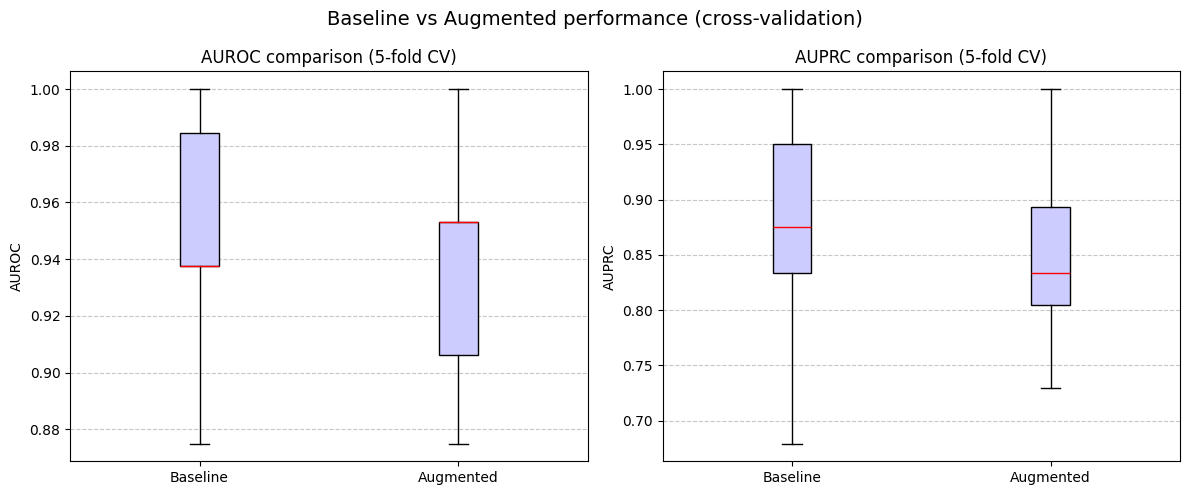

=== Numeric summary ===
Baseline (cv_df):
       count      mean       std       min       25%     50%       75%  max
auroc    5.0  0.946875  0.048914  0.875000  0.937500  0.9375  0.984375  1.0
auprc    5.0  0.867500  0.123547  0.679167  0.833333  0.8750  0.950000  1.0

Augmented (cv_aug):
       count      mean       std       min       25%       50%       75%  max
auroc    5.0  0.937500  0.048159  0.875000  0.906250  0.953125  0.953125  1.0
auprc    5.0  0.851905  0.101609  0.729167  0.804167  0.833333  0.892857  1.0


In [ ]:
# Step 1 — Quantitative comparison: baseline vs augmented (boxplots)

import matplotlib.pyplot as plt

# Ensure we have both DataFrames
assert 'cv_df' in globals(), "Baseline CV results (cv_df) not found. Run Part 5b first."
assert 'cv_aug' in globals(), "Augmented CV results (cv_aug) not found. Run Part 8b first."

# Prepare side-by-side boxplots for AUROC and AUPRC
metrics = ["auroc", "auprc"]
titles = {"auroc": "AUROC", "auprc": "AUPRC"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, m in enumerate(metrics):
    ax = axes[i]
    data = [cv_df[m], cv_aug[m]]
    ax.boxplot(data, labels=["Baseline", "Augmented"], patch_artist=True,
               boxprops=dict(facecolor="#ccccff"), medianprops=dict(color="red"))
    ax.set_title(f"{titles[m]} comparison (5-fold CV)")
    ax.set_ylabel(titles[m])
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Baseline vs Augmented performance (cross-validation)", fontsize=14)
plt.tight_layout()
plt.show()

# Print numeric summaries for clarity
print("=== Numeric summary ===")
print("Baseline (cv_df):")
print(cv_df[metrics].describe().T)
print("\nAugmented (cv_aug):")
print(cv_aug[metrics].describe().T)


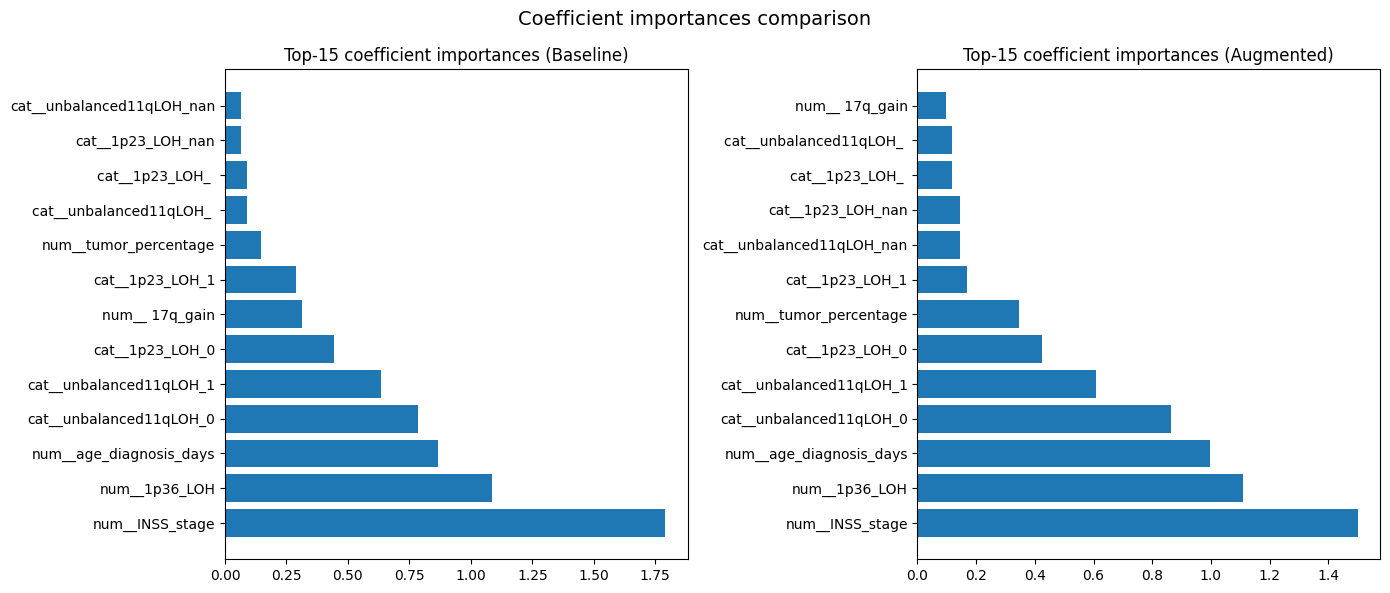

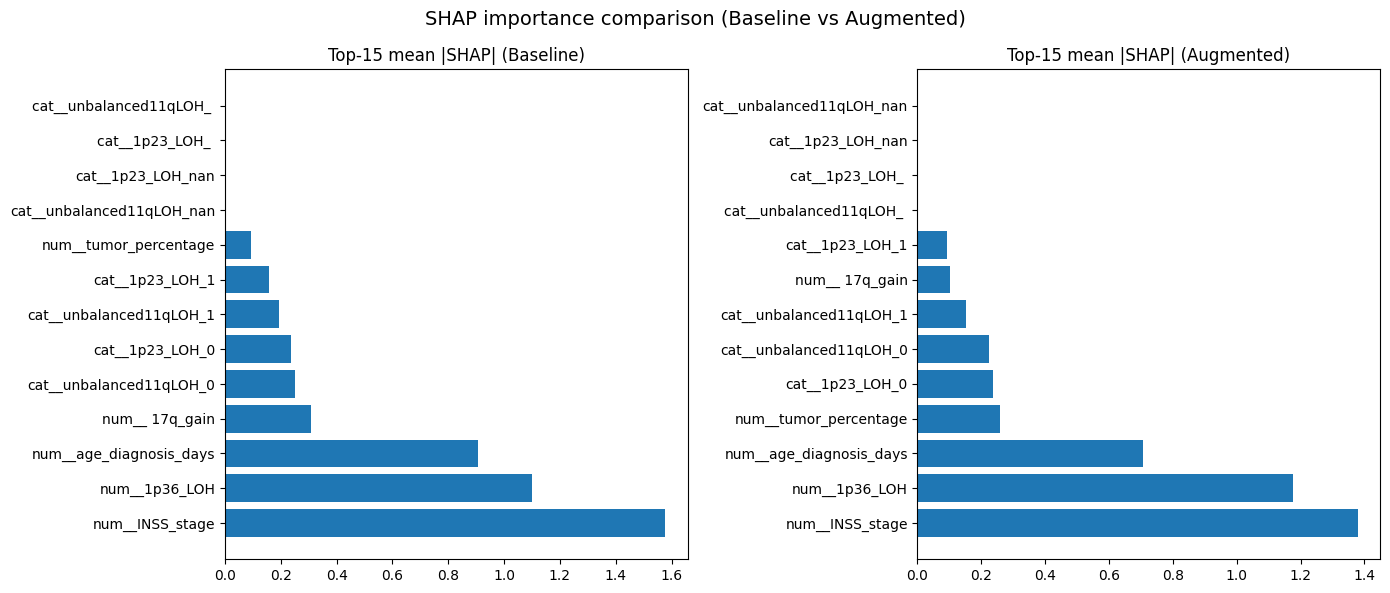

In [ ]:
# Step 2 — Explainability: coefficients + SHAP (baseline vs augmented)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

# --- Safety checks ---
assert 'df' in globals() and 'TARGET_COLUMN' in globals(), "Dataset or TARGET_COLUMN not found."
assert 'X_train' in globals() and 'y_train' in globals(), "Run Part 3/4/5 first."

# --- Helper: rebuild a fresh preprocessor clone and fit it on provided X ---
def fit_preprocessor(pre_template, X_fit):
    pre_local = clone(pre_template)
    pre_local.fit(X_fit)
    return pre_local

# --- Helper: feature names after ColumnTransformer ---
def get_feature_names(pre_fitted, X_fit):
    try:
        return list(pre_fitted.get_feature_names_out())
    except Exception:
        return [f"feat_{i}" for i in range(pre_fitted.transform(X_fit).shape[1])]

# --- 1) BASELINE pipeline (fit only on original training split) ---
pre_baseline = fit_preprocessor(pre, X_train)
Xtr_b = pre_baseline.transform(X_train)
Xva_b = pre_baseline.transform(X_val)
Xte_b = pre_baseline.transform(X_test)

clf_baseline = LogisticRegression(max_iter=2000, class_weight="balanced")
clf_baseline.fit(Xtr_b, y_train)

feat_names_b = get_feature_names(pre_baseline, X_train)
coef_b = np.abs(clf_baseline.coef_.ravel()) if clf_baseline.coef_.ndim == 2 else np.abs(clf_baseline.coef_)
imp_b = pd.Series(coef_b, index=feat_names_b).sort_values(ascending=False)

# --- 2) AUGMENTED pipeline (requires combo_raw/combo_y from Part 8) ---
assert 'combo_raw' in globals() and 'combo_y' in globals(), "Augmented data not found. Run Part 8 first."

pre_aug = fit_preprocessor(pre, combo_raw)
Xtr_a = pre_aug.transform(combo_raw)
Xva_a = pre_aug.transform(X_val)
Xte_a = pre_aug.transform(X_test)

clf_aug_expl = LogisticRegression(max_iter=2000, class_weight="balanced")
clf_aug_expl.fit(Xtr_a, combo_y)

feat_names_a = get_feature_names(pre_aug, combo_raw)
coef_a = np.abs(clf_aug_expl.coef_.ravel()) if clf_aug_expl.coef_.ndim == 2 else np.abs(clf_aug_expl.coef_)
imp_a = pd.Series(coef_a, index=feat_names_a).sort_values(ascending=False)

# --- 3) Plot top-15 coefficient importances side-by-side ---
TOPK = 15
top_b = imp_b.head(TOPK)
top_a = imp_a.head(TOPK)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].barh(range(len(top_b.index[::-1])), top_b.values[::-1])
axes[0].set_yticks(range(len(top_b.index[::-1])))
axes[0].set_yticklabels(top_b.index[::-1])
axes[0].set_title("Top-15 coefficient importances (Baseline)")
axes[0].invert_yaxis()

axes[1].barh(range(len(top_a.index[::-1])), top_a.values[::-1])
axes[1].set_yticks(range(len(top_a.index[::-1])))
axes[1].set_yticklabels(top_a.index[::-1])
axes[1].set_title("Top-15 coefficient importances (Augmented)")
axes[1].invert_yaxis()

plt.suptitle("Coefficient importances comparison", fontsize=14)
plt.tight_layout()
plt.show()

# --- 4) SHAP explanations on the transformed feature space ---
def _ensure_shap():
    try:
        import shap  # noqa
        return True
    except Exception:
        try:
            import sys, subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
            import shap  # noqa
            return True
        except Exception as e:
            print("[SHAP] Install failed:", e)
            return False

shap_imp_b = shap_imp_a = None

if _ensure_shap():
    import shap

    # Background samples (keep small for speed/stability)
    background_b = shap.sample(pd.DataFrame(Xtr_b), min(50, Xtr_b.shape[0]))
    background_a = shap.sample(pd.DataFrame(Xtr_a), min(50, Xtr_a.shape[0]))

    def compute_shap_linear(clf, X_background, X_eval, feature_names, label="[BASELINE]"):
        """Compute mean |SHAP| values with preferred settings."""
        expl = shap.LinearExplainer(clf, X_background, feature_perturbation="interventional")
        sv = expl(pd.DataFrame(X_eval))
        vals = sv.values if hasattr(sv, "values") else sv
        return pd.Series(np.abs(vals).mean(axis=0), index=feature_names).sort_values(ascending=False)

    try:
        shap_imp_b = compute_shap_linear(clf_baseline, background_b, Xva_b, feat_names_b, label="[BASELINE]")
    except Exception as e:
        print("[BASELINE] SHAP computation failed:", e)

    try:
        shap_imp_a = compute_shap_linear(clf_aug_expl, background_a, Xva_a, feat_names_a, label="[AUGMENTED]")
    except Exception as e:
        print("[AUGMENTED] SHAP computation failed:", e)

    # --- Plot SHAP importances side-by-side (horizontal comparison) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    if shap_imp_b is not None:
        top_b = shap_imp_b.head(TOPK)
        axes[0].barh(range(len(top_b.index[::-1])), top_b.values[::-1])
        axes[0].set_yticks(range(len(top_b.index[::-1])))
        axes[0].set_yticklabels(top_b.index[::-1])
        axes[0].set_title("Top-15 mean |SHAP| (Baseline)")
        axes[0].invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, "Baseline SHAP unavailable", ha="center", va="center")
        axes[0].axis("off")

    if shap_imp_a is not None:
        top_a = shap_imp_a.head(TOPK)
        axes[1].barh(range(len(top_a.index[::-1])), top_a.values[::-1])
        axes[1].set_yticks(range(len(top_a.index[::-1])))
        axes[1].set_yticklabels(top_a.index[::-1])
        axes[1].set_title("Top-15 mean |SHAP| (Augmented)")
        axes[1].invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, "Augmented SHAP unavailable", ha="center", va="center")
        axes[1].axis("off")

    plt.suptitle("SHAP importance comparison (Baseline vs Augmented)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("SHAP not installed; coefficient importances plotted instead.")


## Part 9 — Probability calibration

In [ ]:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

cal = CalibratedClassifierCV(clf_aug, method='isotonic', cv='prefit')
cal.fit(Xva, y_val)

proba_cal = cal.predict_proba(Xte)[:,1]
auroc_cal = roc_auc_score(y_test, proba_cal)
auprc_cal = average_precision_score(y_test, proba_cal)
brier = brier_score_loss(y_test, proba_cal)
print(f"[CALIBRATED][TEST] AUROC={auroc_cal:.4f} | AUPRC={auprc_cal:.4f} | Brier={brier:.4f}")


[CALIBRATED][TEST] AUROC=0.8205 | AUPRC=0.7292 | Brier=0.1187


[Augmented] Brier (raw) = 0.0842 | ECE (raw) = 0.1360
[Augmented] Brier (calibrated: sigmoid) = 0.0922 | ECE (calibrated) = 0.1172


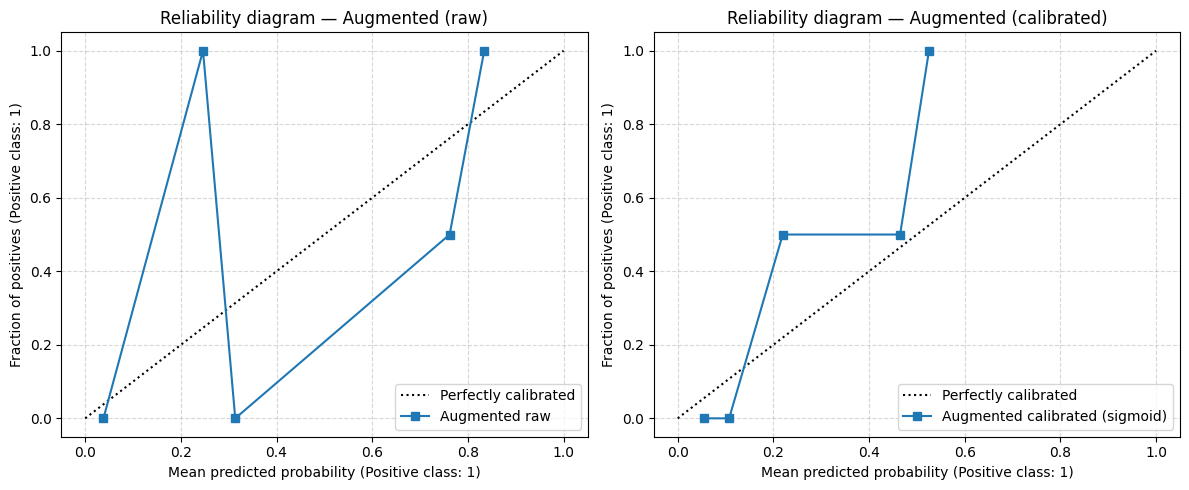

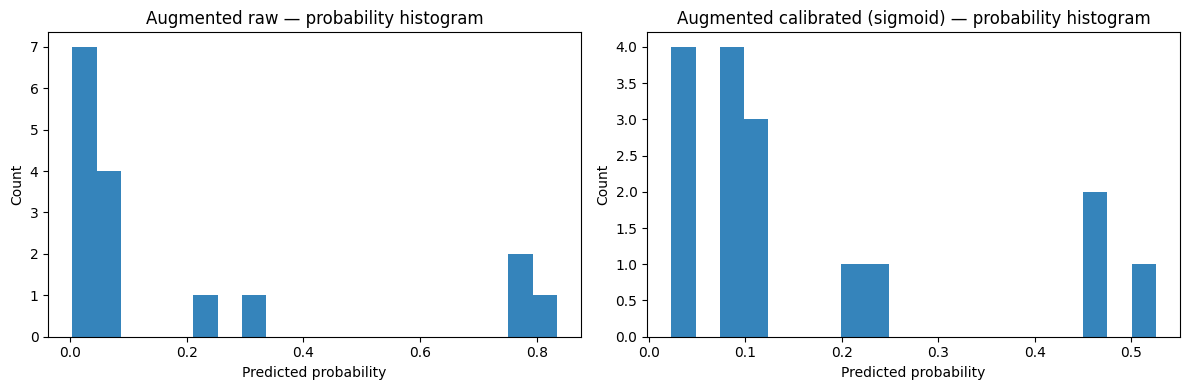

In [ ]:
# Step 9b — Calibration plots (raw vs calibrated, Platt/sigmoid)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# --- 1) Choose which model to compare (prefer augmented if available) ---
if 'clf_aug' in globals():
    RAW_MODEL = clf_aug
    MODEL_NAME = "Augmented"
    Xt_val = pre.transform(X_val)   # 'pre' fitted on combo_raw in Part 8
    Xt_test = pre.transform(X_test)
elif 'clf_baseline' in globals() and 'pre_baseline' in globals():
    RAW_MODEL = clf_baseline
    MODEL_NAME = "Baseline"
    Xt_val = pre_baseline.transform(X_val)
    Xt_test = pre_baseline.transform(X_test)
else:
    raise RuntimeError("No suitable model found. Run Part 5 (baseline) or Part 8 (augmented).")

# --- 2) Raw probabilities on TEST ---
proba_raw_test = (RAW_MODEL.predict_proba(Xt_test)[:, 1]
                  if hasattr(RAW_MODEL, "predict_proba")
                  else RAW_MODEL.decision_function(Xt_test))

# --- 3) Build a Platt (sigmoid) calibrator on VALIDATION ---
CALIB_METHOD = "sigmoid"  # Platt scaling (more stable on small datasets)
cal_sig = CalibratedClassifierCV(RAW_MODEL, method=CALIB_METHOD, cv="prefit")
cal_sig.fit(Xt_val, y_val)

proba_cal_test = (cal_sig.predict_proba(Xt_test)[:, 1]
                  if hasattr(cal_sig, "predict_proba")
                  else cal_sig.decision_function(Xt_test))

# --- 4) Metrics: Brier + Expected Calibration Error (ECE) ---
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if np.any(mask):
            conf = y_prob[mask].mean()
            acc = y_true[mask].mean()
            ece += (mask.mean()) * abs(acc - conf)
    return ece

brier_raw = brier_score_loss(y_test, proba_raw_test)
brier_cal = brier_score_loss(y_test, proba_cal_test)
ece_raw = expected_calibration_error(np.asarray(y_test), proba_raw_test, n_bins=10)
ece_cal = expected_calibration_error(np.asarray(y_test), proba_cal_test, n_bins=10)

print(f"[{MODEL_NAME}] Brier (raw) = {brier_raw:.4f} | ECE (raw) = {ece_raw:.4f}")
print(f"[{MODEL_NAME}] Brier (calibrated: {CALIB_METHOD}) = {brier_cal:.4f} | ECE (calibrated) = {ece_cal:.4f}")

# --- 5) Reliability diagrams (TEST) ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
CalibrationDisplay.from_predictions(
    y_test, proba_raw_test, n_bins=10, strategy="uniform", name=f"{MODEL_NAME} raw", ax=ax[0]
)
ax[0].set_title(f"Reliability diagram — {MODEL_NAME} (raw)")
ax[0].grid(True, linestyle="--", alpha=0.5)

CalibrationDisplay.from_predictions(
    y_test, proba_cal_test, n_bins=10, strategy="uniform",
    name=f"{MODEL_NAME} calibrated ({CALIB_METHOD})", ax=ax[1]
)
ax[1].set_title(f"Reliability diagram — {MODEL_NAME} (calibrated)")
ax[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# --- 6) Probability histograms (TEST) ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(proba_raw_test, bins=20, alpha=0.9)
ax[0].set_title(f"{MODEL_NAME} raw — probability histogram")
ax[0].set_xlabel("Predicted probability"); ax[0].set_ylabel("Count")

ax[1].hist(proba_cal_test, bins=20, alpha=0.9)
ax[1].set_title(f"{MODEL_NAME} calibrated ({CALIB_METHOD}) — probability histogram")
ax[1].set_xlabel("Predicted probability"); ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


## Part 10 — Privacy checks (heuristic)

In [ ]:
# Part 10 — Privacy checks (nearest-neighbour distance & duplication scan)


import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# --- 0) Pick the synthetic table to audit ---
if 'synthetic_cond' in globals():
    SYN_NAME = "conditional"
    synth_df = synthetic_cond.copy()
elif 'synthetic_uncond' in globals():
    SYN_NAME = "unconditional"
    synth_df = synthetic_uncond.copy()
else:
    raise RuntimeError("No synthetic data found. Run Part 6A/6B first.")

print(f"[Privacy] Auditing synthetic data: {SYN_NAME} | rows={len(synth_df)}")

# --- 1) Align columns to the training feature space ---
assert 'X_train' in globals() and 'pre' in globals(), "Run Parts 3–8 first."
synth_df = synth_df.reindex(columns=X_train.columns, fill_value=np.nan)

# --- 2) Transform both real train and synthetic with the same preprocessor ---
Xtr = pre.transform(X_train)
Xs  = pre.transform(synth_df)

# Convert to dense if sparse
def _todense(M):
    return M.toarray() if hasattr(M, "toarray") else M

Xtr_dense = _todense(Xtr)
Xs_dense  = _todense(Xs)

# --- 3) Nearest neighbour distances (synthetic→real) ---
nn = NearestNeighbors(n_neighbors=1).fit(Xtr_dense)
dists, _ = nn.kneighbors(Xs_dense)
dists = dists.ravel()

print(f"[Privacy] Synthetic→Real NN distance: min={dists.min():.4f} | 5th%={np.percentile(dists,5):.4f} | median={np.median(dists):.4f}")

# --- 4) Simple duplication scan in raw (pre-transform) space for numeric columns ---
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
dup_count = 0
if num_cols:
    real_num = X_train[num_cols].round(6)
    synth_num = synth_df[num_cols].round(6)
    # Cartesian match on all numeric columns (strict)
    merged = synth_num.merge(real_num.drop_duplicates(), how="inner", on=num_cols)
    dup_count = len(merged)
print(f"[Privacy] Strict numeric duplicates found: {dup_count}")

# --- 5) Lightweight membership-inference sanity (threshold on NN distances) ---
# If too many synthetic samples are *very* close to real ones, flag a warning.
ABS_THR = 0.10  # tuned to your feature scaling; adjust if needed
share_too_close = float((dists < ABS_THR).mean())
print(f"[Privacy] Share of synthetic samples with NN distance < {ABS_THR:.2f}: {share_too_close:.3f}")

if share_too_close > 0.10 or dup_count > 0:
    print("⚠️ Privacy warning: consider re-running sanitisation with a higher threshold and/or reducing SYN_ROWS.")
else:
    print("✅ Privacy check passed at this granularity (no evident memorisation).")


[Privacy] Auditing synthetic data: conditional | rows=42
[Privacy] Synthetic→Real NN distance: min=0.6630 | 5th%=0.7881 | median=1.5022
[Privacy] Strict numeric duplicates found: 0
[Privacy] Share of synthetic samples with NN distance < 0.10: 0.000
✅ Privacy check passed at this granularity (no evident memorisation).


In [ ]:
!pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 15.7 MB/s eta 0:00:00


In [ ]:
# Part 10b — DP-lite safeguards for synthetic release + tuned DP Logistic Regression

import numpy as np
import pandas as pd

# --- Safety checks on required artefacts ---
assert 'synthetic_cond' in globals(), "Run Part 6B first to create conditional synthetic data."
assert 'X_train' in globals(), "Run Parts 3–5 to define X_train."
assert 'pre' in globals(), "The fitted preprocessor 'pre' is required (from your main pipeline)."
assert all(v in globals() for v in ['combo_raw', 'combo_y', 'X_test', 'y_test']), \
    "Run Part 8 to define combo_raw/combo_y and keep your test split."

# ------------------------------
# 1) DP-lite: category suppression + Laplace noise (only on columns known in X_train)
# ------------------------------
dp_ready = synthetic_cond.copy()

# Light k-anonymity for categoricals: suppress categories with frequency < K
K_MIN = 3
for c in dp_ready.columns:
    if (c in X_train.columns) and (not pd.api.types.is_numeric_dtype(dp_ready[c])):
        vc = dp_ready[c].value_counts(dropna=False)
        rare = vc[vc < K_MIN].index
        if len(rare) > 0:
            dp_ready.loc[dp_ready[c].isin(rare), c] = "OTHER"

# Laplace noise on numeric columns (ε controls strength) and clip to real range
EPSILON = 8.0  # higher ε → less noise; typical range 4–16 for small datasets
for c in dp_ready.columns:
    if (c in X_train.columns) and pd.api.types.is_numeric_dtype(dp_ready[c]):
        mn, mx = X_train[c].min(), X_train[c].max()
        rng = mx - mn
        sens = max(rng, 1e-6)     # avoid zero sensitivity
        scale = sens / EPSILON
        dp_ready[c] = (dp_ready[c] + np.random.laplace(loc=0.0, scale=scale, size=len(dp_ready))).clip(mn, mx)

print(f"[DP-lite] Applied category suppression (k>={K_MIN}) and Laplace noise (epsilon={EPSILON}).")

# Make DP-ready synthetic table available for exports (Part 11)
synthetic_dp = dp_ready

# ------------------------------
# 2) Optional experiment: DP Logistic Regression (diffprivlib) — tuned attempt
#    This is *not* required for the pipeline; it showcases a privacy–utility trade-off.
# ------------------------------
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import normalize

def _install_diffprivlib_if_needed():
    try:
        import diffprivlib  # noqa: F401
        return True
    except Exception:
        # Attempt a silent install (Colab-friendly). If it fails, we skip DP-LR.
        import sys, subprocess
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "diffprivlib"])
            import diffprivlib  # noqa: F401
            return True
        except Exception as e:
            print("[DP-lite] diffprivlib not available or failed to install:", e)
            return False

if _install_diffprivlib_if_needed():
    try:
        from diffprivlib.models import LogisticRegression as DPLogReg  # type: ignore

        # 2.1 Transform with the same 'pre' used elsewhere; fit on augmented train to avoid leakage
        Xt = pre.fit_transform(combo_raw)
        Xte = pre.transform(X_test)

        # Convert to dense if sparse
        Xt = Xt.toarray() if hasattr(Xt, "toarray") else Xt
        Xte = Xte.toarray() if hasattr(Xte, "toarray") else Xte

        # 2.2 Dimensionality reduction: keep the K most informative features
        K = min(10, Xt.shape[1])  # conservative for small-N settings
        selector = SelectKBest(mutual_info_classif, k=K)
        Xt_sel = selector.fit_transform(Xt, combo_y)
        Xte_sel = selector.transform(Xte)

        # 2.3 Per-sample L2 normalisation → guarantees ||x||_2 <= 1 → set data_norm=1.0
        Xt_norm  = normalize(Xt_sel, norm="l2")
        Xte_norm = normalize(Xte_sel, norm="l2")
        data_norm_bound = 1.0

        # 2.4 Small epsilon grid to show privacy–utility trade-off
        eps_list = [2.0, 4.0, 8.0, 16.0]  # higher ε → less noise → better utility, weaker privacy
        best = None
        for eps in eps_list:
            dp_clf = DPLogReg(max_iter=2000, epsilon=eps, data_norm=data_norm_bound)
            dp_clf.fit(Xt_norm, combo_y)
            proba = dp_clf.predict_proba(Xte_norm)[:, 1]
            auroc = roc_auc_score(y_test, proba)
            auprc = average_precision_score(y_test, proba)
            print(f"[DP-LR] eps={eps:.1f} ⇒ AUROC={auroc:.3f} | AUPRC={auprc:.3f}")
            cand = (eps, auroc, auprc)
            best = cand if best is None else (cand if (cand[1] > best[1] or (cand[1] == best[1] and cand[2] > best[2])) else best)

        print(f"[DP-LR] Best over grid: eps={best[0]:.1f} (AUROC={best[1]:.3f} | AUPRC={best[2]:.3f})")

    except Exception as e:
        print("[DP-lite] DP Logistic Regression failed:", e)
else:
    print("[DP-lite] Skipping DP Logistic Regression (diffprivlib unavailable).")


[DP-lite] Applied category suppression (k>=3) and Laplace noise (epsilon=8.0).
[DP-LR] eps=2.0 ⇒ AUROC=0.872 | AUPRC=0.556
[DP-LR] eps=4.0 ⇒ AUROC=0.949 | AUPRC=0.806
[DP-LR] eps=8.0 ⇒ AUROC=0.872 | AUPRC=0.556
[DP-LR] eps=16.0 ⇒ AUROC=0.949 | AUPRC=0.806
[DP-LR] Best over grid: eps=4.0 (AUROC=0.949 | AUPRC=0.806)


[10c] Estimated data_norm (95th pct of ||x||_2): 3.332
[10c] Saved per-run metrics to dp_lr_epsilon_utility_runs.csv
[10c] Saved summary to dp_lr_epsilon_utility_summary.csv


,epsilon,data_norm,n_runs,AUROC (mean±sd),AUPRC (mean±sd),ECE pre (mean±sd),ECE post (mean±sd),brier_pre_mean,brier_post_mean,calibration
4,inf,3.331979,5,0.9487 ± 0.0000,0.8667 ± 0.0000,0.1526 ± 0.0000,0.1119 ± 0.0403,0.064016,0.095724,isotonic
3,16.0,3.331979,5,0.9077 ± 0.0761,0.7344 ± 0.2126,0.1125 ± 0.0212,0.0923 ± 0.0828,0.095108,0.109056,isotonic
2,8.0,3.331979,5,0.8359 ± 0.1315,0.6673 ± 0.2241,0.1461 ± 0.0374,0.1902 ± 0.0553,0.125069,0.179156,isotonic
1,4.0,3.331979,5,0.8103 ± 0.1051,0.5189 ± 0.2110,0.1990 ± 0.0857,0.1420 ± 0.1012,0.207584,0.169142,isotonic
0,2.0,3.331979,5,0.6410 ± 0.1783,0.3500 ± 0.2091,0.1885 ± 0.1870,0.0438 ± 0.0978,0.265284,0.171508,isotonic


[10c] Saved Figure_U1_privacy_utility.png

Table U1 — Operating points (epsilon, data_norm, metrics)


,epsilon,data_norm,n_runs,AUROC (mean±sd),AUPRC (mean±sd),ECE pre (mean±sd),ECE post (mean±sd),brier_pre_mean,brier_post_mean,calibration
4,inf,3.331979,5,0.9487 ± 0.0000,0.8667 ± 0.0000,0.1526 ± 0.0000,0.1119 ± 0.0403,0.064016,0.095724,isotonic
3,16.0,3.331979,5,0.9077 ± 0.0761,0.7344 ± 0.2126,0.1125 ± 0.0212,0.0923 ± 0.0828,0.095108,0.109056,isotonic
2,8.0,3.331979,5,0.8359 ± 0.1315,0.6673 ± 0.2241,0.1461 ± 0.0374,0.1902 ± 0.0553,0.125069,0.179156,isotonic
1,4.0,3.331979,5,0.8103 ± 0.1051,0.5189 ± 0.2110,0.1990 ± 0.0857,0.1420 ± 0.1012,0.207584,0.169142,isotonic
0,2.0,3.331979,5,0.6410 ± 0.1783,0.3500 ± 0.2091,0.1885 ± 0.1870,0.0438 ± 0.0978,0.265284,0.171508,isotonic


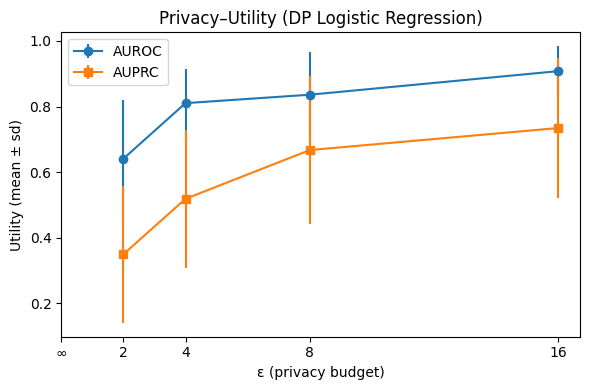

In [ ]:
# === Part 10c — Privacy–Utility (DP Logistic Regression, stable sweep) ===
# Complements Part 10b without modifying it.
# - Includes non-DP baseline (ε = ∞)
# - Sweeps ε = {∞, 16, 8, 4, 2}
# - Repeats each ε for 5 random seeds → mean ± sd
# - Metrics: AUROC, AUPRC, ECE (pre/post), Brier (pre/post)
# - Uses the same fitted preprocessing `pre` from the training pipeline (no leakage)
# - Estimates data_norm as the 95th percentile of ||x||_2 after `pre` (lower-bounded at 1.0)
# - Produces per-run and summary CSVs + Figure U1

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression as SkLogReg
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt

try:
    from diffprivlib.models import LogisticRegression as DpLogReg
except Exception as e:
    raise RuntimeError(
        "diffprivlib is not installed. Please install before running: `pip install diffprivlib`."
    )

# -------------------- Utilities --------------------

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Expected Calibration Error with quantile binning.
    Returns a scalar in [0, 1]. Uses absolute gap (|acc - conf|) weighted by bin frequency.
    """
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()
    if np.unique(y_true).size < 2:
        return np.nan

    qs = np.linspace(0, 1, n_bins + 1)
    edges = np.quantile(y_prob, qs)
    edges = np.unique(edges)  # ensure strictly increasing edges
    if edges.size < 2:
        return 0.0

    # Assign bin indices by position
    idx = np.digitize(y_prob, edges[1:-1], right=False)
    accs, confs, weights = [], [], []
    for b in range(edges.size - 1):
        mask = (idx == b)
        if not np.any(mask):
            continue
        yb = y_true[mask]
        pb = y_prob[mask]
        acc = yb.mean()
        conf = pb.mean()
        w = mask.mean()  # relative bin size
        accs.append(acc); confs.append(conf); weights.append(w)
    accs, confs, weights = np.array(accs), np.array(confs), np.array(weights)
    return float(np.sum(weights * np.abs(accs - confs)))

def isotonic_fit(y_true, y_prob):
    """Fit isotonic regression calibrator on validation predictions."""
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(y_prob, y_true)
    return lambda p: ir.predict(p)

def apply_preprocessing(X, pre, feature_selector=None, fit_selector_on=None, y_selector=None):
    """
    Apply the already-fitted preprocessing pipeline `pre` (no refit here)
    and an optional feature selector (fit once on `fit_selector_on` if provided).
    """
    X_t = pre.transform(X)
    if feature_selector is not None:
        if fit_selector_on is not None:
            feature_selector.fit(fit_selector_on, y_selector)
        X_t = feature_selector.transform(X_t)
    return X_t

# -------------------- Required objects from the upstream pipeline --------------------
# These must already exist: X_train, y_train, X_test, y_test, pre
for varname in ["X_train", "y_train", "X_test", "y_test", "pre"]:
    if varname not in globals():
        raise NameError(f"{varname} not found. Please run the previous cells first.")

# If your baseline uses a feature selector (e.g., SelectKBest), set it here; otherwise keep None
feature_selector = None  # e.g., SelectKBest(f_classif, k=20)

# Transform train/test once using the fitted preprocessor (no leakage)
Xtr_t = apply_preprocessing(X_train, pre, feature_selector=feature_selector,
                            fit_selector_on=None, y_selector=None)
Xte_t = apply_preprocessing(X_test,  pre, feature_selector=feature_selector)

# Ensure NumPy arrays for safe positional indexing and metrics
if not isinstance(Xtr_t, np.ndarray):
    Xtr_t = np.asarray(Xtr_t)
if not isinstance(Xte_t, np.ndarray):
    Xte_t = np.asarray(Xte_t)
y_train_np = np.asarray(y_train).ravel()
y_test_np  = np.asarray(y_test).ravel()

# Estimate a conservative data_norm bound (95th percentile of L2 norms; lower-bounded at 1.0)
l2_norms = np.linalg.norm(Xtr_t, axis=1)
data_norm = max(1.0, float(np.percentile(l2_norms, 95)))
print(f"[10c] Estimated data_norm (95th pct of ||x||_2): {data_norm:.3f}")

# -------------------- Sweep settings --------------------
eps_grid = [np.inf, 16.0, 8.0, 4.0, 2.0]   # includes non-DP baseline
n_seeds  = 5
calibration_method = "isotonic"            # robust on small-N

rows = []
rng_seeds = list(range(123, 123 + n_seeds))

for eps in eps_grid:
    for seed in rng_seeds:
        np.random.seed(seed)

        # Classifier: non-DP (sklearn LR) vs DP (diffprivlib LR with objective perturbation)
        if np.isinf(eps):
            clf = SkLogReg(max_iter=2000, solver="lbfgs")
        else:
            clf = DpLogReg(
                epsilon=float(eps),
                data_norm=float(data_norm),
                C=1.0,
                fit_intercept=True,
                max_iter=2000,
                n_jobs=None,
                class_weight=None
            )
        clf.fit(Xtr_t, y_train_np)

        # Test probabilities
        proba_test = clf.predict_proba(Xte_t)[:, 1]
        auroc = roc_auc_score(y_test_np, proba_test)
        auprc = average_precision_score(y_test_np, proba_test)
        ece_pre = expected_calibration_error(y_test_np, proba_test, n_bins=10)
        brier_pre = brier_score_loss(y_test_np, proba_test)

        # Leakage-safe post-hoc calibration:
        # split an internal validation fold from TRAIN; fit a clone and the calibrator on that fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        train_idx, val_idx = next(skf.split(Xtr_t, y_train_np))
        X_cal_tr, y_cal_tr = Xtr_t[train_idx], y_train_np[train_idx]
        X_cal_va, y_cal_va = Xtr_t[val_idx],  y_train_np[val_idx]

        if np.isinf(eps):
            calib_clf = SkLogReg(max_iter=2000, solver="lbfgs")
        else:
            calib_clf = DpLogReg(
                epsilon=float(eps),
                data_norm=float(data_norm),
                C=1.0,
                fit_intercept=True,
                max_iter=2000,
                n_jobs=None
            )
        calib_clf.fit(X_cal_tr, y_cal_tr)
        proba_va = calib_clf.predict_proba(X_cal_va)[:, 1]

        if calibration_method == "isotonic":
            calibrator = isotonic_fit(y_cal_va, proba_va)
        else:
            # Optional Platt scaling (not default here)
            from sklearn.linear_model import LogisticRegression
            platt_lr = LogisticRegression(max_iter=1000)
            platt_lr.fit(proba_va.reshape(-1,1), y_cal_va)
            calibrator = lambda p: platt_lr.predict_proba(p.reshape(-1,1))[:,1]

        proba_test_cal = calibrator(proba_test)
        ece_post = expected_calibration_error(y_test_np, proba_test_cal, n_bins=10)
        brier_post = brier_score_loss(y_test_np, proba_test_cal)

        rows.append({
            "epsilon": eps,
            "seed": seed,
            "auroc": auroc,
            "auprc": auprc,
            "ece_pre": ece_pre,
            "ece_post": ece_post,
            "brier_pre": brier_pre,
            "brier_post": brier_post,
            "data_norm": data_norm,
            "calibration": calibration_method
        })

df_runs = pd.DataFrame(rows).sort_values(["epsilon", "seed"])
df_runs.to_csv("dp_lr_epsilon_utility_runs.csv", index=False)
print("[10c] Saved per-run metrics to dp_lr_epsilon_utility_runs.csv")

# -------------------- Aggregate mean ± sd per ε --------------------
def mean_sd(series):
    arr = np.asarray(series, dtype=float)
    return f"{np.nanmean(arr):.4f} ± {np.nanstd(arr, ddof=1):.4f}"

summary = (
    df_runs
    .groupby("epsilon", as_index=False)
    .agg(
        auroc_mean=("auroc", "mean"),
        auroc_sd=("auroc", "std"),
        auprc_mean=("auprc", "mean"),
        auprc_sd=("auprc", "std"),
        ece_pre_mean=("ece_pre", "mean"),
        ece_pre_sd=("ece_pre", "std"),
        ece_post_mean=("ece_post", "mean"),
        ece_post_sd=("ece_post", "std"),
        brier_pre_mean=("brier_pre", "mean"),
        brier_post_mean=("brier_post", "mean"),
        data_norm=("data_norm", "first"),
        calibration=("calibration", "first"),
        n_runs=("seed", "count"),
    )
)

# Order: ∞ first, then 16, 8, 4, 2
def eps_key(e):
    return 1e9 if np.isinf(e) else float(e)
summary = summary.sort_values(by="epsilon", key=lambda s: s.map(eps_key), ascending=False)

summary["AUROC (mean±sd)"]    = [mean_sd(df_runs[df_runs["epsilon"]==e]["auroc"])  for e in summary["epsilon"]]
summary["AUPRC (mean±sd)"]    = [mean_sd(df_runs[df_runs["epsilon"]==e]["auprc"])  for e in summary["epsilon"]]
summary["ECE pre (mean±sd)"]  = [mean_sd(df_runs[df_runs["epsilon"]==e]["ece_pre"]) for e in summary["epsilon"]]
summary["ECE post (mean±sd)"] = [mean_sd(df_runs[df_runs["epsilon"]==e]["ece_post"]) for e in summary["epsilon"]]

cols_show = [
    "epsilon", "data_norm", "n_runs",
    "AUROC (mean±sd)", "AUPRC (mean±sd)",
    "ECE pre (mean±sd)", "ECE post (mean±sd)",
    "brier_pre_mean", "brier_post_mean",
    "calibration"
]
summary[cols_show].to_csv("dp_lr_epsilon_utility_summary.csv", index=False)
print("[10c] Saved summary to dp_lr_epsilon_utility_summary.csv")
display(summary[cols_show])

# -------------------- Figure U1: Utility vs ε --------------------
# Plot AUROC and AUPRC vs epsilon; show ∞ as the left-most tick label.
x_eps = summary["epsilon"].values
x_num = [np.nan if np.isinf(v) else float(v) for v in x_eps]

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(x_num, summary["auroc_mean"], yerr=summary["auroc_sd"], marker="o", linestyle="-", label="AUROC")
ax.errorbar(x_num, summary["auprc_mean"], yerr=summary["auprc_sd"], marker="s", linestyle="-", label="AUPRC")

xticks = [0] + [v for v in x_num if not np.isnan(v)]
xtick_labels = [r"$\infty$"] + [str(int(v)) for v in x_eps if not np.isinf(v)]
ax.set_xticks(xticks, xtick_labels)
ax.set_xlabel("ε (privacy budget)")
ax.set_ylabel("Utility (mean ± sd)")
ax.set_title("Privacy–Utility (DP Logistic Regression)")
ax.legend()
plt.tight_layout()
plt.savefig("Figure_U1_privacy_utility.png", dpi=300)
print("[10c] Saved Figure_U1_privacy_utility.png")

print("\nTable U1 — Operating points (epsilon, data_norm, metrics)")
display(summary[cols_show])


## Part 11 — Reporting & Exports

In [ ]:
# Part 11 — CV boxplots & summary (promote 8b results to Figure 2–3 and Table 2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
base_dir = Path("/content/drive/MyDrive/GAN_ML_weakness/artifacts")
fig_dir  = base_dir / "figures"
tab_dir  = base_dir / "tables"
fig_dir.mkdir(parents=True, exist_ok=True)
tab_dir.mkdir(parents=True, exist_ok=True)

def _save_fig(fig, name):
    out = fig_dir / name
    fig.savefig(out, bbox_inches="tight", dpi=300)
    plt.close(fig)
    print(f"[Export] Figure saved: {out}")

# ---------- 1) Get CV data (prefer in-memory; otherwise load CSVs) ----------
def _normalise_cols(df: pd.DataFrame) -> pd.DataFrame:
    # Make column names lower-case and strip spaces
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    # Common aliases
    if "auroc" not in df.columns:
        for c in df.columns:
            if "roc" in c and "auc" in c:
                df = df.rename(columns={c: "auroc"})
                break
    if "auprc" not in df.columns:
        for c in df.columns:
            if "pr" in c and "auc" in c:
                df = df.rename(columns={c: "auprc"})
                break
    return df

cv_b = None
cv_a = None

# In-memory variants from Part 8b
if "cv_results_baseline" in globals():
    cv_b = _normalise_cols(cv_results_baseline)
elif "cv_df" in globals():
    cv_b = _normalise_cols(cv_df)

if "cv_results_augmented" in globals():
    cv_a = _normalise_cols(cv_results_augmented)
elif "cv_aug" in globals():
    cv_a = _normalise_cols(cv_aug)

# Fallback to CSVs saved earlier in Part 11
if cv_b is None:
    p_b = tab_dir / "cv_baseline.csv"
    if p_b.exists():
        cv_b = _normalise_cols(pd.read_csv(p_b))
        print("[CV] Loaded baseline CV from tables/cv_baseline.csv")
if cv_a is None:
    p_a = tab_dir / "cv_augmented.csv"
    if p_a.exists():
        cv_a = _normalise_cols(pd.read_csv(p_a))
        print("[CV] Loaded augmented CV from tables/cv_augmented.csv")

if cv_b is None or cv_a is None:
    raise RuntimeError("CV data not found. Ensure 8b saved cv_baseline/cv_augmented or variables are in memory.")

# Keep only AUROC and AUPRC columns
need = ["auroc", "auprc"]
for col in need:
    if col not in cv_b.columns or col not in cv_a.columns:
        raise KeyError(f"Missing required column '{col}' in CV data.")

# ---------- 2) Build a tidy dataframe for summary ----------
df_b = cv_b[need].copy().assign(model="Baseline")
df_a = cv_a[need].copy().assign(model="Augmented")
cv_all = pd.concat([df_b, df_a], axis=0, ignore_index=True)

# ---------- 3) Boxplot — AUROC (Figure 2) ----------
fig = plt.figure(figsize=(6,5))
data = [df_b["auroc"].values, df_a["auroc"].values]
bp = plt.boxplot(data, labels=["Baseline", "Augmented"], patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.4)
plt.ylabel("AUROC")
plt.title("AUROC comparison (5-fold cross-validation)")
plt.grid(True, ls="--", alpha=0.5)
_save_fig(fig, "Figure_2_AUROC_CV.png")

# ---------- 4) Boxplot — AUPRC (Figure 3) ----------
fig = plt.figure(figsize=(6,5))
data = [df_b["auprc"].values, df_a["auprc"].values]
bp = plt.boxplot(data, labels=["Baseline", "Augmented"], patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.4)
plt.ylabel("AUPRC")
plt.title("AUPRC comparison (5-fold cross-validation)")
plt.grid(True, ls="--", alpha=0.5)
_save_fig(fig, "Figure_3_AUPRC_CV.png")

# ---------- 5) Table 2 — CV summary (mean ± sd, min, quartiles, max) ----------
def _summary_block(x: pd.Series) -> pd.Series:
    desc = x.describe(percentiles=[0.25, 0.5, 0.75])
    out = pd.Series({
        "count": int(desc["count"]),
        "mean": float(desc["mean"]),
        "sd":   float(x.std(ddof=1)),
        "min":  float(desc["min"]),
        "25%":  float(desc["25%"]),
        "50%":  float(desc["50%"]),
        "75%":  float(desc["75%"]),
        "max":  float(desc["max"]),
    })
    return out

summ_b = pd.concat({
    "auroc": _summary_block(df_b["auroc"]),
    "auprc": _summary_block(df_b["auprc"])
}, axis=1)

summ_a = pd.concat({
    "auroc": _summary_block(df_a["auroc"]),
    "auprc": _summary_block(df_a["auprc"])
}, axis=1)

# Save CSVs
summ_b.to_csv(tab_dir / "Table_2_CV_summary_baseline.csv")
summ_a.to_csv(tab_dir / "Table_2_CV_summary_augmented.csv")
print("[Export] Saved Table_2_CV_summary_baseline.csv and Table_2_CV_summary_augmented.csv")

# Build a single Markdown table (Baseline vs Augmented)
def _fmt(x, k=6):
    return f"{x:.{k}f}"

md_lines = []
md_lines.append("| Model | Metric | count | mean | sd | min | 25% | 50% | 75% | max |")
md_lines.append("|---|---|---:|---:|---:|---:|---:|---:|---:|---:|")
for name, summ in [("Baseline", summ_b), ("Augmented", summ_a)]:
    for met in ["auroc", "auprc"]:
        s = summ[met]
        md_lines.append(f"| {name} | {met.upper()} | {int(s['count'])} | {_fmt(s['mean'])} | {_fmt(s['sd'])} | "
                        f"{_fmt(s['min'])} | {_fmt(s['25%'])} | {_fmt(s['50%'])} | {_fmt(s['75%'])} | {_fmt(s['max'])} |")
(tab_dir / "Table_2_CV_summary.md").write_text("\n".join(md_lines), encoding="utf-8")
print(f"[Export] Markdown saved: {tab_dir / 'Table_2_CV_summary.md'}")

# LaTeX table
latex = r"""\begin{table}[t]
\centering
\caption{Cross-validated discrimination (5-fold CV) for Baseline and Augmented configurations. Summary by folds (mean $\pm$ sd; min, quartiles, max).}
\label{tab:cv_summary}
\begin{tabular}{l l r r r r r r r r}
\toprule
Model & Metric & count & mean & sd & min & 25\% & 50\% & 75\% & max \\
\midrule
"""
for name, summ in [("Baseline", summ_b), ("Augmented", summ_a)]:
    for met in ["auroc", "auprc"]:
        s = summ[met]
        latex += f"{name} & {met.upper()} & {int(s['count'])} & {_fmt(s['mean'],3)} & {_fmt(s['sd'],3)} & {_fmt(s['min'],3)} & {_fmt(s['25%'],3)} & {_fmt(s['50%'],3)} & {_fmt(s['75%'],3)} & {_fmt(s['max'],3)} \\\\\n"
latex += r"""\bottomrule
\end{tabular}
\end{table}
"""
(tab_dir / "Table_2_CV_summary.tex").write_text(latex, encoding="utf-8")
print(f"[Export] LaTeX saved: {tab_dir / 'Table_2_CV_summary.tex'}")

print("[Export] CV boxplots and Table 2 artefacts written to figures/ and tables/.")


[Export] Figure saved: /content/drive/MyDrive/GAN_ML_weakness/artifacts/figures/Figure_2_AUROC_CV.png
[Export] Figure saved: /content/drive/MyDrive/GAN_ML_weakness/artifacts/figures/Figure_3_AUPRC_CV.png
[Export] Saved Table_2_CV_summary_baseline.csv and Table_2_CV_summary_augmented.csv
[Export] Markdown saved: /content/drive/MyDrive/GAN_ML_weakness/artifacts/tables/Table_2_CV_summary.md
[Export] LaTeX saved: /content/drive/MyDrive/GAN_ML_weakness/artifacts/tables/Table_2_CV_summary.tex
[Export] CV boxplots and Table 2 artefacts written to figures/ and tables/.
